In [1]:
import jax
from jax import numpy as np
from jax import scipy as sp
from jax import random

from numpy.polynomial.hermite import hermgauss

import scipy.cluster.hierarchy as sch

import paragami

from copy import deepcopy

# regression-mixture libraries
from structure_vb_lib import structure_model_lib, posterior_quantities_lib, data_utils

# BNP libraries
from bnpmodeling_runjingdev import result_loading_utils, influence_lib, log_phi_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib
from bnpmodeling_runjingdev.sensitivity_lib import get_cross_hess

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 18

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp

# Load data

In [3]:
g_obs = data_utils.load_thrush_data()[0]

print(g_obs.shape)

n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]
n_allele = g_obs.shape[-1]


loading thrush data from : 
../data/thrush_data/thrush-data.str
(155, 7, 2, 21)


# Load initial fit

In [4]:
out_folder = '../fits/thrush_fits/'
out_filename = 'thrush_fit'
alpha0 = 3.0

In [5]:
fit_file = out_folder + out_filename + '_alpha' + str(alpha0) + '.npz'

In [6]:
print('loading fit from ', fit_file)
vb_init_dict, vb_params_paragami, \
    prior_params_dict, prior_params_paragami, \
        gh_loc, gh_weights, meta_data = \
            structure_model_lib.load_structure_fit(fit_file)

vb_init_free = vb_params_paragami.flatten(vb_init_dict, free = True)


loading fit from  ../fits/thrush_fits/thrush_fit_alpha3.0.npz


In [7]:
print(vb_params_paragami)

OrderedDict:
	[pop_freq_dirichlet_params] = NumericArrayPattern (20, 7, 21) (lb=0.0, ub=inf)
	[ind_admix_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (155, 19) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (155, 19) (lb=0.0, ub=inf)


# Load influence results

In [8]:
influence_file = out_folder + out_filename + '_alpha' + str(alpha0) + '_infl_funcs.npz'

print(influence_file) 

influence_results = np.load(influence_file)

../fits/thrush_fits/thrush_fit_alpha3.0_infl_funcs.npz


In [9]:
# check that things in the influence file match things in my fit file
assert np.all(influence_results['vb_opt'] == vb_init_free)
assert np.abs(influence_results['kl'] - meta_data['final_kl']) < 1e-10

# Define posterior quantity

In [10]:
# seed that was saved in computing the influence functions
prng_key = jax.random.PRNGKey(influence_results['seed'])

threshold = 0

@jax.jit
def get_e_num_clusters(vb_free): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return posterior_quantities_lib.get_e_num_clusters(g_obs,
                                                       vb_params_dict,
                                                       gh_loc, gh_weights,
                                                       threshold = 0,
                                                       n_samples = 1000, 
                                                       prng_key = prng_key)

@jax.jit
def get_e_num_clusters_pred(vb_free): 
    vb_params_dict = vb_params_paragami.fold(vb_free, free = True)
    
    return posterior_quantities_lib.\
            get_e_num_pred_clusters(vb_params_dict,
                                    gh_loc,
                                    gh_weights, 
                                    n_samples = 1000,
                                    threshold = 0, 
                                    prng_key = prng_key,
                                    return_samples = False)


# Plot influence function

In [11]:
logit_v_grid = influence_results['logit_v_grid']

In [12]:
# the prior (for plotting)
def p0(logit_v, alpha0): 
    return np.exp(influence_lib.get_log_logitstick_prior(logit_v, alpha0))

In [13]:
# function to get worst-case log-phi
def get_wc_log_phi_grid(influence_grid): 
    # returns log_phi at points logit_v_grid
    # just for plotting
    
    worst_case = influence_lib.WorstCasePerturbation(influence_fun = None, 
                                                    logit_v_grid = logit_v_grid, 
                                                    delta = 1.,
                                                    cached_influence_grid = influence_grid)

    return worst_case.log_phi(logit_v_grid), worst_case.change_points


In [25]:
def plot_influence_grid(influence_grid, influence_grid_x_prior, ax): 
    
    # plot y = 0 line
    for i in range(3): 
        ax[i].axhline(0, color = 'black')
    
    # plot influence function
    ax[0].plot(logit_v_grid, influence_grid, color = '#43a2ca')
    
    # plot prior
    ax[1].plot(logit_v_grid, p0(logit_v_grid, alpha0), 
                  color = '#7bccc4')
    
    # plot influence x prior
    ax[2].plot(logit_v_grid, influence_grid_x_prior, color = '#0868ac')
    
    # plot l-inf worst-case perturbation
#     wc_log_phi, change_points = get_wc_log_phi_grid(influence_grid)
#     ax[3].plot(logit_v_grid, wc_log_phi, color = 'grey')
#     ax[3].fill_between(logit_v_grid, 0, wc_log_phi, color = 'grey', alpha = 0.5)
    
#     for cp in change_points: 
#         ax[2].axvline(cp, color = 'grey', linestyle = 'dashed')
    
    ax[0].set_ylabel('influence')
    ax[1].set_ylabel('prior')
    ax[2].set_ylabel('influence x prior')
    # ax[3].set_ylabel('worst-case log phi')


### influence on cluster allocations

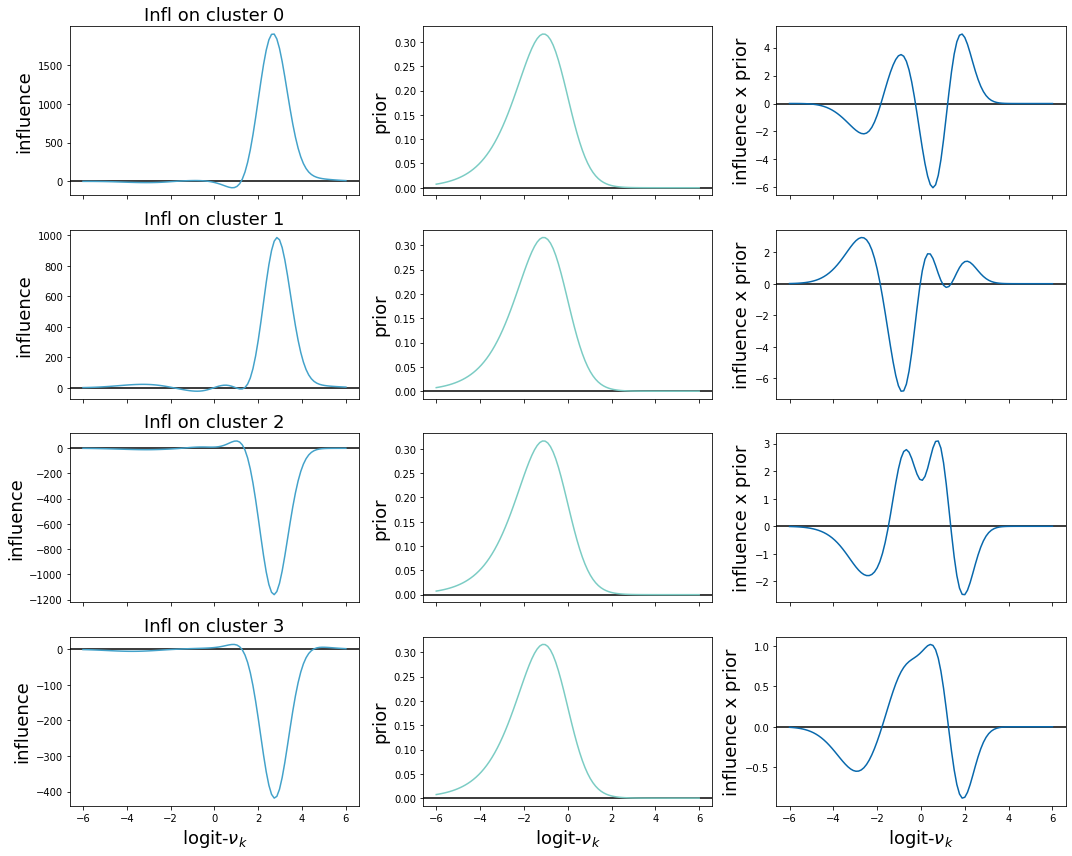

In [78]:
fig, axarr = plt.subplots(4, 3, figsize = (15, 12),  sharex = True) 

for k in range(4): 
    plot_influence_grid(influence_results['e_num_ind{}_infl'.format(k)], 
                        influence_results['e_num_ind{}_infl_x_prior'.format(k)],
                        axarr[k])
    
    axarr[k, 0].set_title('Infl on cluster {}'.format(k))
    
for j in range(3): 
    axarr[-1, j].set_xlabel(r'logit-$\nu_k$')
    
fig.tight_layout()

fig.savefig('../../writing/notes_for_tamara/figures/influence_mixture_weights.png')

### influnce on expected number of clusters

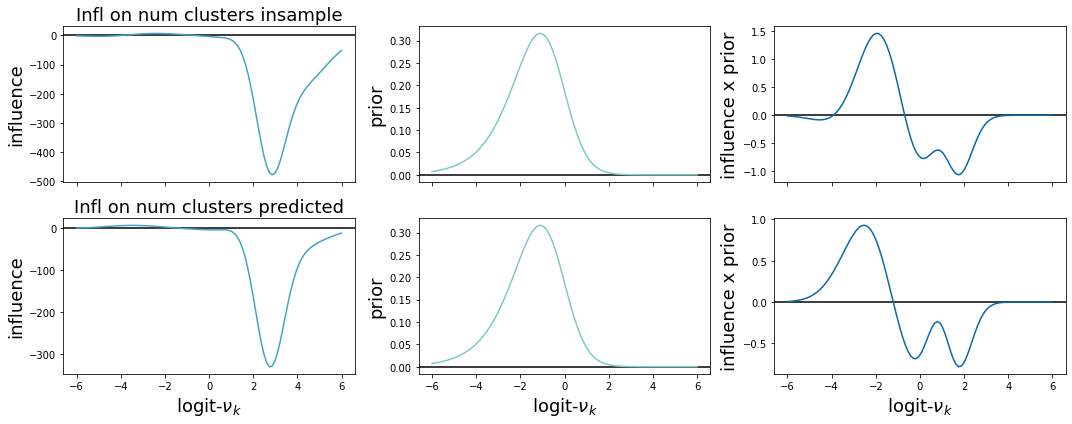

In [77]:
fig, axarr = plt.subplots(2, 3, figsize = (15, 6),  sharex = True) 

plot_influence_grid(influence_results['num_clust_infl'], 
                    influence_results['num_clust_infl_x_prior'],
                    axarr[0])
axarr[0, 0].set_title('Infl on num clusters insample')

plot_influence_grid(influence_results['num_clust_pred_infl'], 
                    influence_results['num_clust_pred_infl_x_prior'],
                    axarr[1])
axarr[1, 0].set_title('Infl on num clusters predicted')

for j in range(3): 
    axarr[-1, j].set_xlabel(r'logit-$\nu_k$')

fig.tight_layout()

fig.savefig('../../writing/notes_for_tamara/figures/influence_num_clust.png')

# Load refitted vb parameters

In [38]:
num_mus = 6

In [39]:
def _load_refit_results_for_mu(mu_indx): 
    match_crit = out_filename + '_stepbump_mu{}_eps'.format(mu_indx) + '\d+.npz'
    
    # load free parameters
    vb_refit_list, epsilon_vec, meta_data_list = \
        result_loading_utils.load_refit_files_epsilon(out_folder, match_crit)
    
    # get mu
    mus = result_loading_utils._load_meta_data_from_list(meta_data_list, 'mu')
    mu = np.unique(mus)
    assert len(mu) == 1
    
    # check prior parameter matches
    assert np.all(result_loading_utils._load_meta_data_from_list(meta_data_list, 'dp_prior_alpha') == \
                  alpha0)
    
    return vb_refit_list, epsilon_vec, mu

In [40]:
def load_all_refit_results(): 
    
    mu_vec = onp.zeros(num_mus)
    
    for mu_indx in range(num_mus): 
        vb_refit_list, _epsilon_vec, mu= _load_refit_results_for_mu(mu_indx)
        
        if mu_indx == 0: 
            epsilon_vec = deepcopy(_epsilon_vec)
            vb_refit_array = onp.zeros((num_mus, len(epsilon_vec), vb_refit_list.shape[-1]))
            
        assert np.all(epsilon_vec == _epsilon_vec)
            
        vb_refit_array[mu_indx] = vb_refit_list
        mu_vec[mu_indx] = mu
        
    return np.array(vb_refit_array), epsilon_vec, mu_vec


In [41]:
vb_refit_array, epsilon_vec, _mu_vec = load_all_refit_results()
print(_mu_vec)

[-6. -4. -2.  0.  2.  4.]


In [43]:
mu_vec = np.concatenate((_mu_vec, np.array([2 * _mu_vec[-1] - _mu_vec[-2]])))
print(mu_vec)

[-6. -4. -2.  0.  2.  4.  6.]


# Define step bumps

In [44]:
step_bumps = log_phi_lib.StepPerturbations(mu_vec)

# Function to compute posterior statistic on all refits

In [45]:
def get_refit_g_array(g): 
    
    refit_g_array = onp.zeros(vb_refit_array.shape[0:2])
    
    for i in range(refit_g_array.shape[0]): 
        for j in range(refit_g_array.shape[1]): 
            
            refit_g_array[i, j] = g(vb_refit_array[i, j])
        
    return refit_g_array


# Compute cross-hessians

one cross-hessian for each mu

In [46]:
cross_hess_list = []

for i in range(len(mu_vec) - 1): 
    # compute linear response stuff
    f_obj = func_sens_lib.FunctionalPerturbationObjective(None, 
                                                          vb_params_paragami, 
                                                          e_log_phi = lambda x,y : step_bumps.e_step_bump(x,y,i), 
                                                          gh_loc = gh_loc, 
                                                          gh_weights = gh_weights, 
                                                          stick_key = 'ind_admix_params')

    cross_hess = get_cross_hess(f_obj.hyper_par_objective_fun)(vb_init_free, 0.)
    
    cross_hess_list.append(cross_hess.squeeze())

# Function to get LR derivatives

In [47]:
def get_lr_results(g, g_name, epsilon_vec):
    lr_g_array = onp.zeros((len(mu_vec) - 1, len(epsilon_vec)))
    
    ghess = influence_results[g_name + '_ghess']
    
    for i in range(len(mu_vec) - 1): 

        # derivative of posterior quantity wrt hyper parameter
        # note the negative sign!
        # the "cross-hessian" is computed using the perturbation to the KL!
        # to get the derivative, we need the inner-product between 
        # the influence operator and the perturbation to the **ELBO**
        # see theorem 2 in giordano
        dg_dhyper = np.dot(ghess, -cross_hess_list[i])
        
        # get lr results
        lr_g_array[i, :] = g(vb_init_free) + dg_dhyper * epsilon_vec
    
    return lr_g_array


# Functions to plot results from influence bumps

In [75]:
def plot_results(g, g_name): 
    
    # influence x prior
    influence_x_prior_grid = influence_results[g_name + '_infl_x_prior']
    
    # get array of posterior values
    refit_g_array = get_refit_g_array(g)

    # lr results
    lr_g_array = get_lr_results(g, 
                                g_name, 
                                epsilon_vec)
    
    diff_refit = refit_g_array - refit_g_array[:, 0:1]
    diff_lr = lr_g_array - lr_g_array[:, 0:1]
    
    max_diff = max(np.abs(diff_refit).max(), 
                   np.abs(diff_lr).max())
    
    
    fig, ax = plt.subplots(num_mus, 4, figsize = (18, 3 * num_mus), 
                           sharex='col')

    for i in range(num_mus): 
            
        ###################
        # plot prior x influence function 
        ###################
        ax[i, 0].plot(logit_v_grid, influence_x_prior_grid)
        # plot y = 0
        ax[i, 0].axhline(0, color = 'black')
                
        # overlay bump
        ax[i, 0].axvspan(mu_vec[i], mu_vec[i+1], color = 'grey', alpha = 0.5)
        ax[i, 0].set_ylabel('influence x prior')
        
        ###################
        # plot perturbed prior 
        ###################
        # compute perturbed prior
        prior_perturbation = func_sens_lib.PriorPerturbation(
                                    alpha0 = alpha0,
                                    log_phi = lambda x : step_bumps.step_bump(x, i), 
                                    logit_v_ub = 10, 
                                    logit_v_lb = -10)
        
        prior_perturbation._plot_priors(ax[i, 1])
        prior_perturbation._plot_priors_constrained(ax[i, 2])
        
        # don't need these labels on every plot
        ax[i, 1].set_xlabel('')
        ax[i, 2].set_xlabel('')
        if i > 0: 
            ax[i, 1].set_title('')
            ax[i, 2].set_title('')
        if i == 0: 
            ax[i, 2].legend()

        ###################
        # plot posterior statistic 
        ###################                        
        # plot refit results
        ax[i, 3].plot(epsilon_vec,
                      refit_g_array[i, :] - refit_g_array[i, 0], 
                      '-o', 
                      label = 'refit', 
                      color = result_loading_utils.refit_color)

        # plot lr results
        ax[i, 3].plot(epsilon_vec, 
                      lr_g_array[i, :] - lr_g_array[i, 0], 
                      '-o', 
                      label = 'lr', 
                      color = result_loading_utils.lr_color)
        
        # make y-axes all the same
        ax[i, 3].set_ylim((-max_diff, max_diff))
        
        ax[i, 3].axhline(0, color = 'black')
        
        if i == 0: 
            ax[i, 3].legend()
        ax[i, 3].set_ylabel(r'$\Delta$ E[#clusters]')
    
    
    
    for j in range(3): 
        ax[-1, j].set_xlabel('logit-sticks')
        
    ax[-1, 3].set_xlabel('epsilon')
    

    fig.tight_layout()
    
    fig.savefig('../../writing/notes_for_tamara/figures/influence_bumps.png')

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.071708e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.484619e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.602876e-01
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.462353e-03
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter 

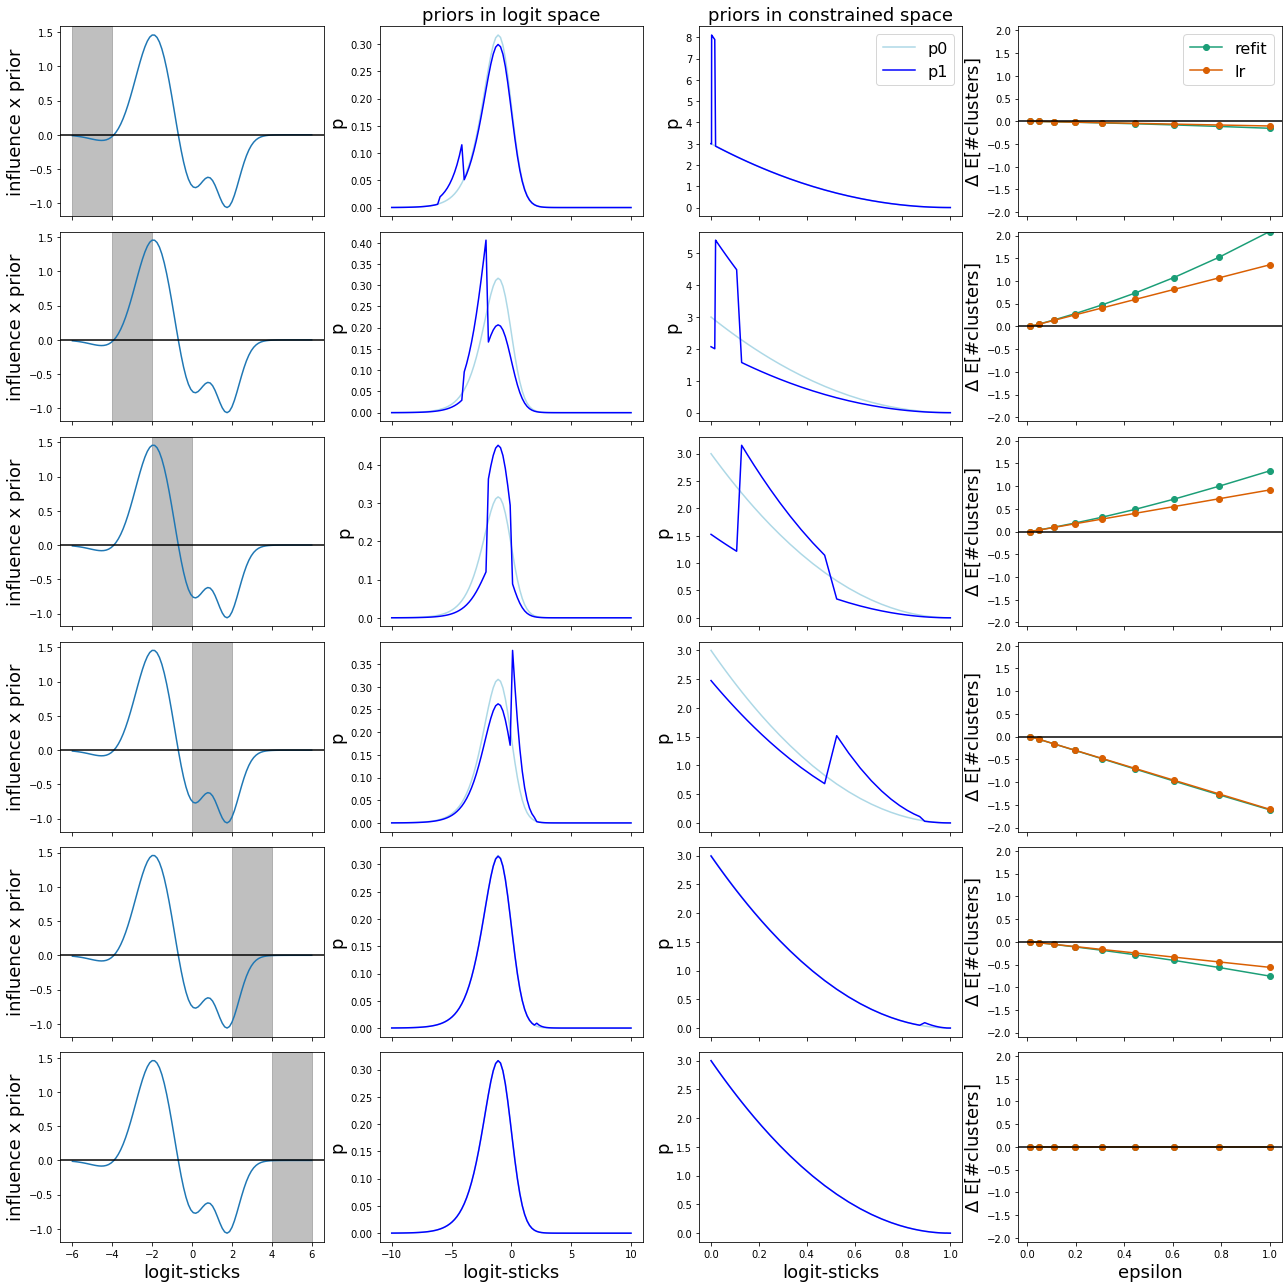

In [76]:
# ignore the warnings ... they all come from the integration function 
# that plots the perturbation. 
# doesn't actually affect results

plot_results(jax.jit(get_e_num_clusters),
             'num_clust')

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.071708e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.484619e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.602876e-01
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.462353e-03
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter 

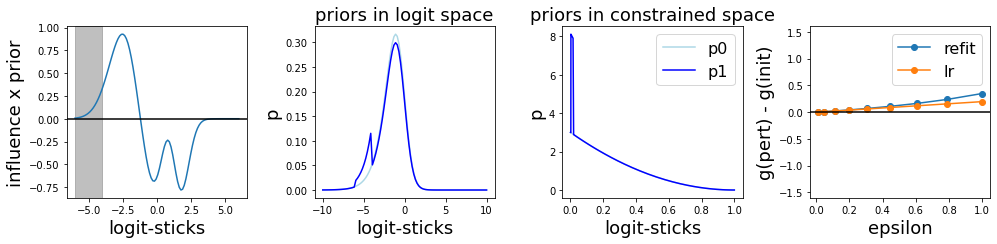

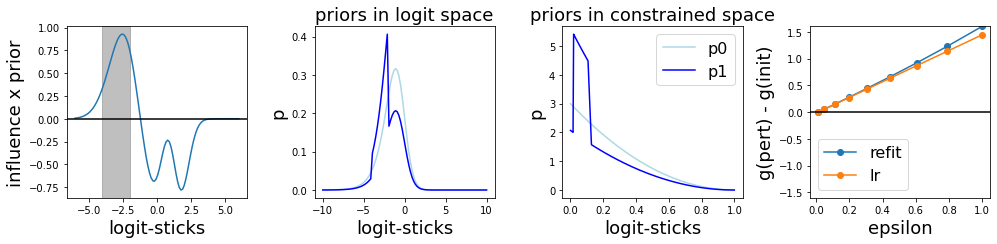

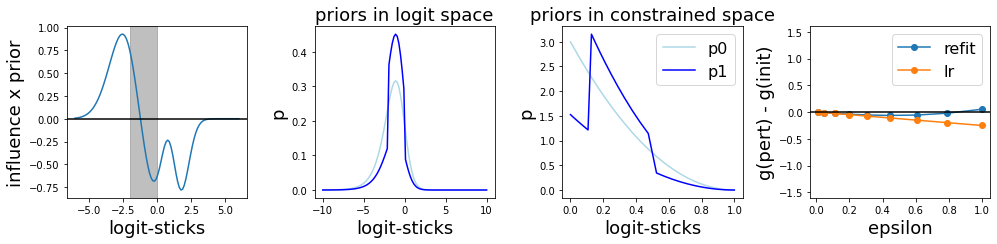

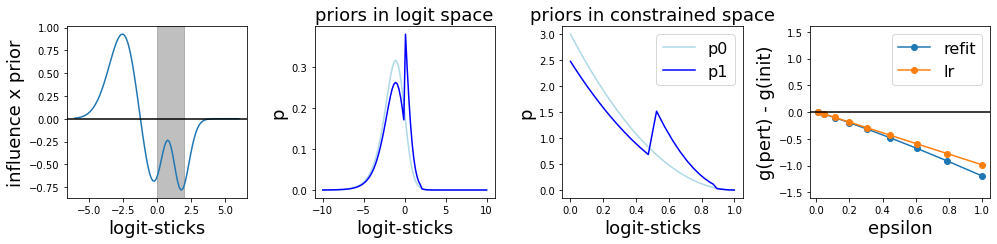

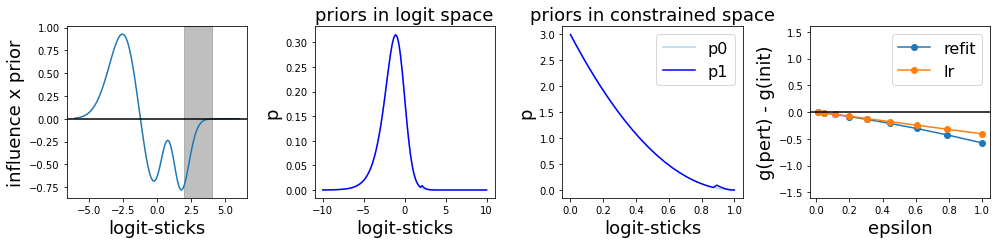

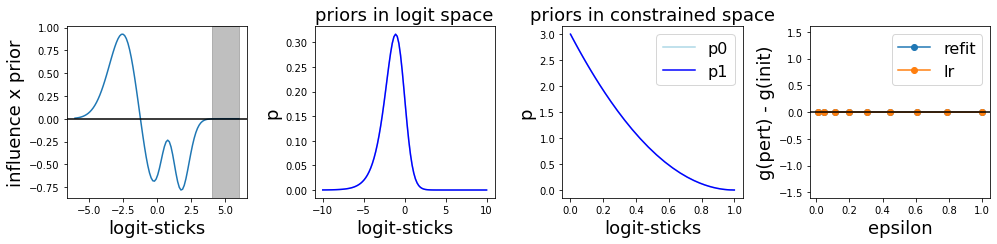

In [50]:
plot_results(jax.jit(get_e_num_clusters_pred),
             'num_clust_pred')